Optimal coefficients found: [1.00441256e-06 1.00428153e-05 1.00297128e-04 9.89868774e-04
 1.00441256e-06 1.00428153e-05 1.00297128e-04 9.89868774e-04]


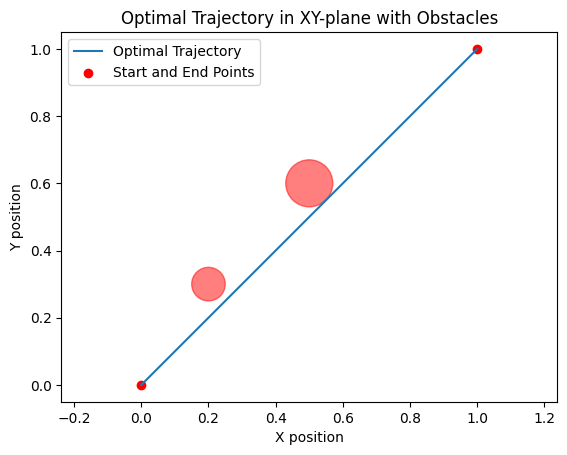

In [4]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Example basis functions: polynomials up to degree n
def polynomial_basis(t, degree=3):
    return np.array([t**i for i in range(degree + 1)]).T

# Function to calculate the obstacle avoidance penalty
def obstacle_penalty(x_trajectory, y_trajectory, obstacles, penalty_scale=100):
    penalty = 0
    for obstacle in obstacles:
        (center_x, center_y), radius = obstacle
        distances = np.sqrt((x_trajectory - center_x)**2 + (y_trajectory - center_y)**2)
        penalty += np.sum(np.exp(penalty_scale * (radius - distances[distances < radius])))
    return penalty

# Objective function to minimize
def objective(coeffs, basis_func, target, time_points, obstacles):
    x_trajectory = basis_func(time_points) @ coeffs[:len(coeffs)//2]
    y_trajectory = basis_func(time_points) @ coeffs[len(coeffs)//2:]
    position_error = np.sum((x_trajectory[-1] - target[0])**2 + (y_trajectory[-1] - target[1])**2)
    collision_penalty = obstacle_penalty(x_trajectory, y_trajectory, obstacles)
    return position_error + collision_penalty

# Initial and final conditions (example)
x0, y0 = 0, 0
xf, yf = 1, 1
Tf = 10  # Final time
n_points = 100  # Number of points in the trajectory
time_points = np.linspace(0, Tf, n_points)

# Target (example)
target = np.array([xf, yf])

# Define obstacles as tuples of ((center_x, center_y), radius)
obstacles = [
    ((0.2, 0.3), 0.05),  # First obstacle with center (x,y) and radius
    ((0.5, 0.6), 0.07),  # Second obstacle with center (x,y) and radius
    # Add more obstacles as needed
]

# Initial guess for coefficients (of the polynomial basis functions)
degree = 3  # Degree of polynomial
initial_guess = np.zeros((degree + 1) * 2)  # Coefficients for both x and y

# Basis function
basis_func = lambda t: polynomial_basis(t, degree=degree)

# Nonlinear optimization to find the best coefficients for both x and y
result = minimize(objective, initial_guess, args=(basis_func, target, time_points, obstacles), method='SLSQP')

if result.success:
    optimal_coeffs = result.x
    print("Optimal coefficients found:", optimal_coeffs)

    # Generate the optimal trajectory for x and y
    optimal_x_trajectory = basis_func(time_points) @ optimal_coeffs[:len(optimal_coeffs)//2]
    optimal_y_trajectory = basis_func(time_points) @ optimal_coeffs[len(optimal_coeffs)//2:]

    # Plotting the trajectory in the xy-plane
    plt.plot(optimal_x_trajectory, optimal_y_trajectory, label='Optimal Trajectory')
    plt.scatter([x0, xf], [y0, yf], color='red', label='Start and End Points')
    # Plotting obstacles
    for obstacle in obstacles:
        (center_x, center_y), radius = obstacle
        circle = plt.Circle((center_x, center_y), radius, color='red', alpha=0.5)
        plt.gca().add_patch(circle)
    plt.title('Optimal Trajectory in XY-plane with Obstacles')
    plt.xlabel('X position')
    plt.ylabel('Y position')
    plt.legend()
    plt.axis('equal')
    plt.show()
else:
    print("Optimization failed:", result.message)
